<a href="https://colab.research.google.com/github/angshumancertified/Solar-PV-forecast-with-Machine-Learning-/blob/main/solarRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solar PV Forecast with Machine Learning <br>
Model: *Reinforcement* <br>
Built and programmed by Angshuman Talukdar <br>
*KIIT University*

installing stable baselines 3 and gym

In [ ]:
pip install stable-baselines3 gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 25.7 MB/s eta 0:00:00


importing dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

load dataset

In [ ]:
data = pd.read_csv('/content/solar_dataset.csv')

drop timestamp

In [ ]:
data = data.drop(['period_end', 'period'], axis=1)

feature engineering

In [ ]:
# here we are using every other feature from the csv file except PV Power as features

features = data.drop(['PV Power'], axis=1)
target = data['PV Power']

training and testing split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

normalize the data

In [ ]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

convert to pytorch tensors

In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

define a pytorch model

In [ ]:
class SolarNet(nn.Module):
    def __init__(self, input_size):
        super(SolarNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

define a pytorch lightning module

In [ ]:
class SolarPowerPredictor(pl.LightningModule):
    def __init__(self, input_size):
        super(SolarPowerPredictor, self).__init__()
        self.model = SolarNet(input_size)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

prepare data for pytorch lightning

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

initialize model and trainer

In [ ]:
input_size = X_train.shape[1]
model = SolarPowerPredictor(input_size)

logger = TensorBoardLogger("tb_logs", name="solar_power_model")
trainer = Trainer(max_epochs=5, logger=logger)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


model training

In [ ]:
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params | Mode 
-----------------------------------------------
0 | model     | SolarNet | 2.4 K  | train
1 | criterion | MSELoss  | 0      | train
-----------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.009     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


model evaluation

In [ ]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for x, y in test_loader:
        y_hat = model(x)
        y_pred.extend(y_hat.numpy())
        y_true.extend(y.numpy())

RMSE and R squared

In [ ]:
rmse = mean_squared_error(y_true, y_pred, squared=False)
r_squared = r2_score(y_true, y_pred)
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

RMSE: 0.9900240302085876
R-squared: 0.9999372825803216


training vs testing data

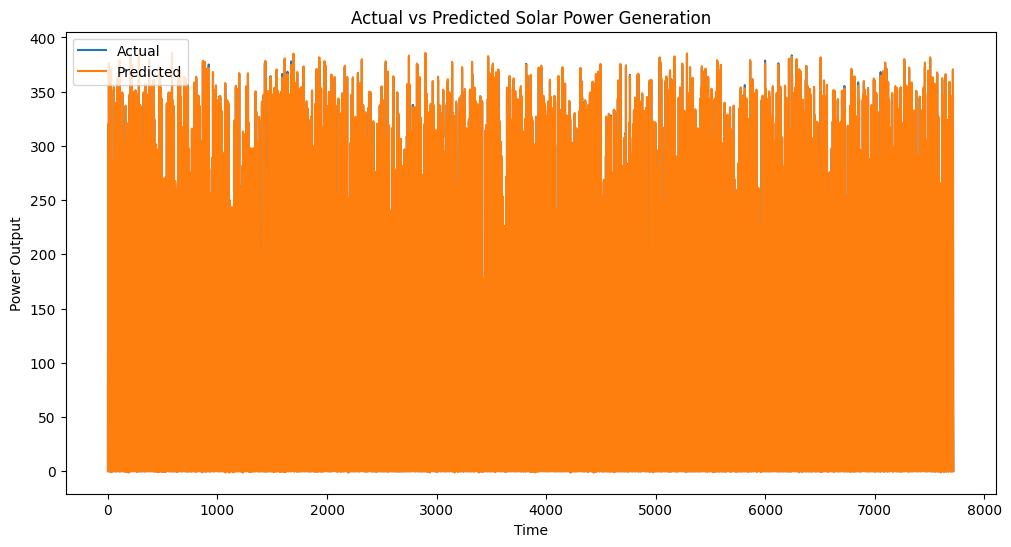

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Solar Power Generation')
plt.xlabel('Time')
plt.ylabel('Power Output')
plt.legend()
plt.show()

error heatmap

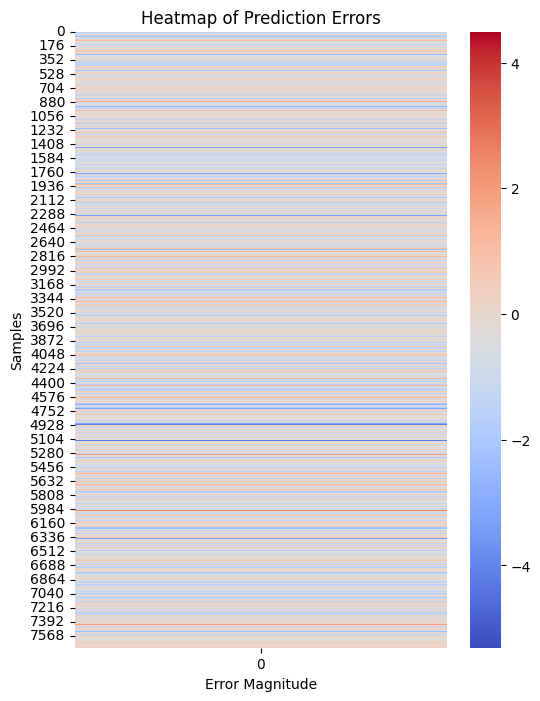

In [ ]:
errors = np.array(y_true) - np.array(y_pred)
errors = errors.reshape(-1, 1)
plt.figure(figsize=(6, 8))
sns.heatmap(errors, cmap='coolwarm', annot=False, cbar=True)
plt.title('Heatmap of Prediction Errors')
plt.xlabel('Error Magnitude')
plt.ylabel('Samples')
plt.show()

feature heatmap

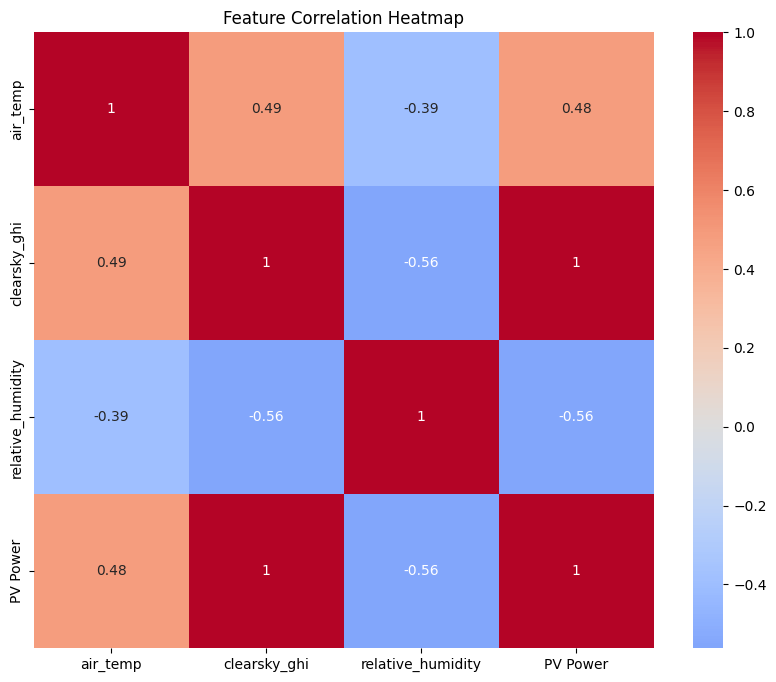

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

training vs testing data distribution plot

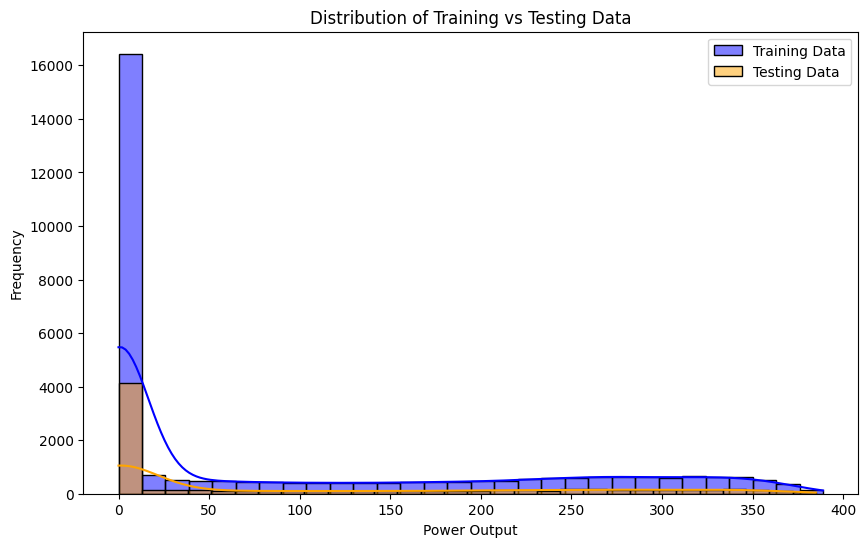

In [ ]:
import seaborn as sns

# Plot distribution for training and testing data
plt.figure(figsize=(10, 6))
sns.histplot(y_train, color='blue', kde=True, label='Training Data', bins=30)
sns.histplot(y_test, color='orange', kde=True, label='Testing Data', bins=30)
plt.title('Distribution of Training vs Testing Data')
plt.xlabel('Power Output')
plt.ylabel('Frequency')
plt.legend()
plt.show()